Tables created: products, dates, sales

ROLAP IMPLEMENTATION

1. Average Revenue by Product Category:
      category  avg_revenue
0        Books   127.500000
1     Clothing    81.666667
2  Electronics  1280.000000

2. Total Sales by Year:
   year  total_quantity  total_revenue
0  2023               7            255
1  2024              13           6645

3. Best-selling Product in Each Category:
      category     name  total_sold
0        Books    Novel           5
1     Clothing  T-Shirt           5
2  Electronics   Laptop           4

MOLAP IMPLEMENTATION

MOLAP Cube - Revenue by Category × Year:
year         2023  2024
category               
Books         255     0
Clothing        0   245
Electronics     0  6400
HOLAP IMPLEMENTATION

HOLAP Detailed Data (first 5 rows):
   sale_id        date  quantity  revenue     category product_name  year  \
0        1  2024-01-15         2     2400  Electronics       Laptop  2024   
1        2  2024-01-20         1      800  Electronics   Smar

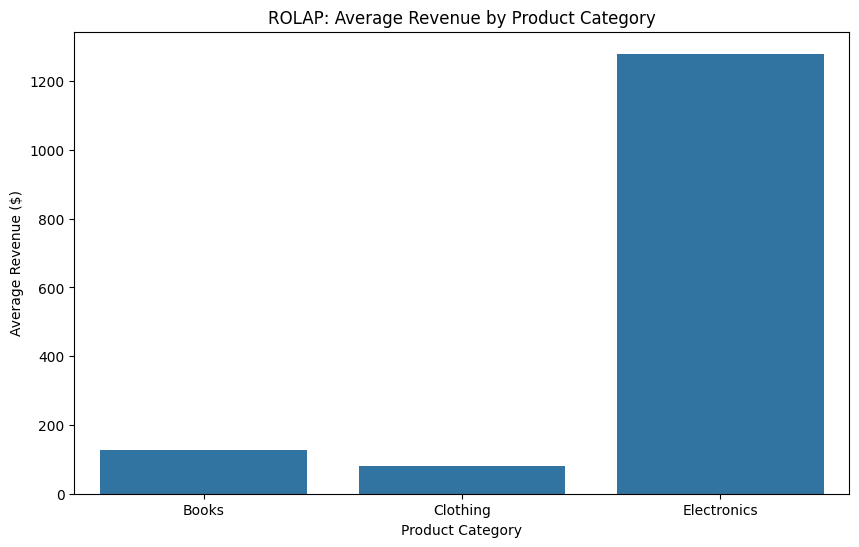

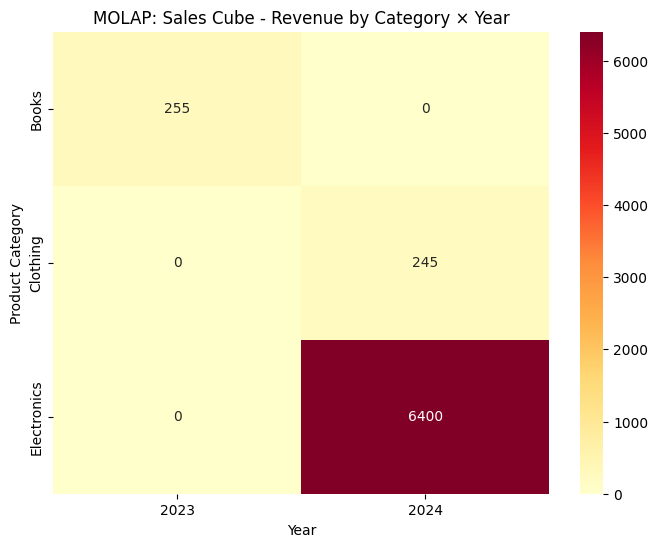

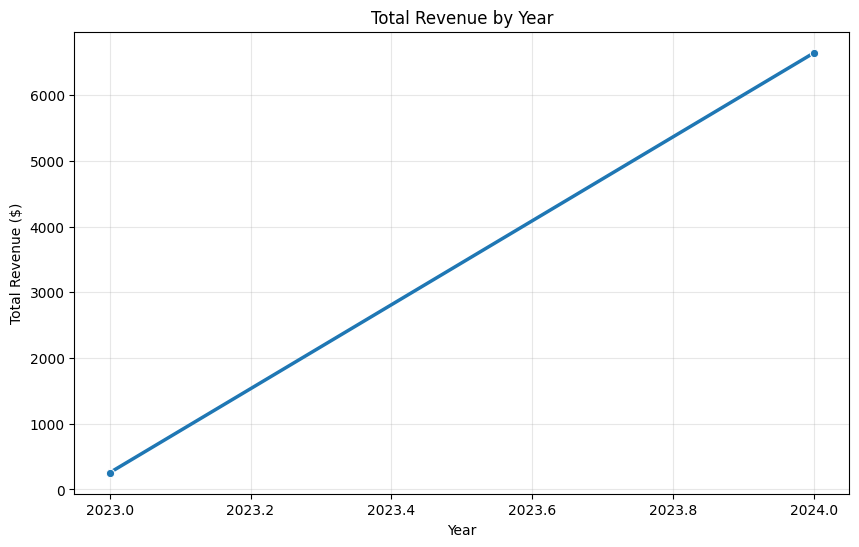

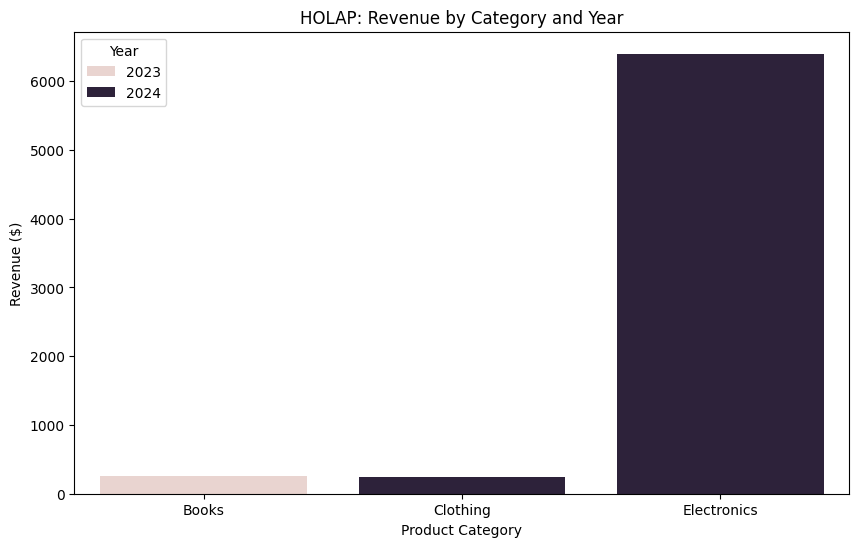


Database connection closed.


In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

def create_connection(db_file="sales_olap.db"):
    conn = sqlite3.connect(db_file)
    return conn


products = pd.DataFrame({
    'product_id': [1, 2, 3, 4, 5, 6],
    'category': ['Electronics', 'Electronics', 'Clothing', 'Clothing', 'Books', 'Books'],
    'name': ['Laptop', 'Smartphone', 'T-Shirt', 'Jeans', 'Novel', 'Textbook'],
    'price': [1200, 800, 25, 60, 15, 90]
})


dates = pd.DataFrame({
    'date': ['2024-01-15', '2024-01-20', '2024-02-10', '2024-03-05', '2024-04-12', '2023-12-20', '2023-11-15'],
    'year': [2024, 2024, 2024, 2024, 2024, 2023, 2023],
    'quarter': [1, 1, 1, 2, 2, 4, 4],
    'month': [1, 1, 2, 3, 4, 12, 11]
})


sales = pd.DataFrame({
    'sale_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'date': ['2024-01-15', '2024-01-20', '2024-02-10', '2024-03-05', '2024-04-12', 
             '2023-12-20', '2023-11-15', '2024-01-15', '2024-02-10', '2024-03-05'],
    'product_id': [1, 2, 1, 3, 4, 5, 6, 2, 3, 1],
    'quantity': [2, 1, 1, 3, 2, 5, 2, 1, 2, 1],
    'revenue': [2400, 800, 1200, 75, 120, 75, 180, 800, 50, 1200]
})


conn = create_connection()
products.to_sql('products', conn, if_exists='replace', index=False)
dates.to_sql('dates', conn, if_exists='replace', index=False)
sales.to_sql('sales', conn, if_exists='replace', index=False)

print("Tables created: products, dates, sales")



# ROLAP Operations
print("\nROLAP Operations")

# Query 1: Average revenue by product category
query1 = """
SELECT p.category, AVG(s.revenue) as avg_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category
"""

rolap_result1 = pd.read_sql_query(query1, conn)
print("\n1. Average Revenue by Product Category:")
print(rolap_result1)

# Query 2: Total sales by year
query2 = """
SELECT d.year, SUM(s.quantity) as total_quantity, SUM(s.revenue) as total_revenue
FROM sales s
JOIN dates d ON s.date = d.date
GROUP BY d.year
"""

rolap_result2 = pd.read_sql_query(query2, conn)
print("\n2. Total Sales by Year:")
print(rolap_result2)

# Query 3: Best-selling product in each category
query3 = """
WITH ranked_products AS (
    SELECT p.category, p.name, SUM(s.quantity) as total_sold,
           ROW_NUMBER() OVER (PARTITION BY p.category ORDER BY SUM(s.quantity) DESC) as rank
    FROM sales s
    JOIN products p ON s.product_id = p.product_id
    GROUP BY p.category, p.name
)
SELECT category, name, total_sold
FROM ranked_products
WHERE rank = 1
"""

rolap_result3 = pd.read_sql_query(query3, conn)
print("\n3. Best-selling Product in Each Category:")
print(rolap_result3)

# MOLAP Operations - Pandas pivot tables
print("\n" + "="*50)
print("MOLAP IMPLEMENTATION")
print("="*50)

# Get data for MOLAP
molap_query = """
SELECT s.revenue, s.quantity, p.category, d.year, d.quarter
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
"""

molap_data = pd.read_sql_query(molap_query, conn)

# MOLAP cube
molap_cube = pd.pivot_table(
    molap_data,
    values='revenue',
    index='category',
    columns='year',
    aggfunc='sum',
    fill_value=0
)

print("\nMOLAP Cube - Revenue by Category × Year:")
print(molap_cube)

# HOLAP Operations
print("HOLAP IMPLEMENTATION")


#ROLAP - Get detailed data
holap_detail_query = """
SELECT s.sale_id, s.date, s.quantity, s.revenue, 
       p.category, p.name as product_name,
       d.year, d.quarter, d.month
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
"""

holap_detail = pd.read_sql_query(holap_detail_query, conn)
print("\nHOLAP Detailed Data (first 5 rows):")
print(holap_detail.head())

# MOLAP - Build aggregated summary
holap_summary = holap_detail.groupby(['category', 'year'])['revenue'].sum().reset_index()
print("\nHOLAP Summary - Revenue by Category and Year:")
print(holap_summary)
print("OLAP OPERATIONS")


# Slice: Fix one dimension
slice_data = holap_detail[holap_detail['year'] == 2024]
print("\n1. SLICE - Sales in 2024 only:")
print(slice_data[['date', 'product_name', 'revenue']].head())

# Dice: Apply multiple filters
dice_data = holap_detail[
    (holap_detail['year'] == 2024) & 
    (holap_detail['quarter'] == 1) & 
    (holap_detail['category'] == 'Electronics')
]
print("\n2. DICE - Sales in Q1 2024 for Electronics only:")
print(dice_data[['date', 'product_name', 'revenue']])

# Roll-Up: Aggregate from product → category → year
print("\n3. ROLL-UP - Aggregation Hierarchy:")

# Product level
product_level = holap_detail.groupby(['year', 'category', 'product_name'])['revenue'].sum().reset_index()
print("\nProduct Level:")
print(product_level)

# Category level (rolled up)
category_level = holap_detail.groupby(['year', 'category'])['revenue'].sum().reset_index()
print("\nCategory Level (Rolled Up):")
print(category_level)

# Year level (further rolled up)
year_level = holap_detail.groupby('year')['revenue'].sum().reset_index()
print("\nYear Level (Further Rolled Up):")
print(year_level)

# Drill-Down: From year → quarter → month
print("\n4. DRILL-DOWN - Temporal Hierarchy:")

# Year view
year_view = holap_detail.groupby('year')['revenue'].sum().reset_index()
print("\nYear View:")
print(year_view)

# Quarter view (drill down from 2024)
quarter_view = holap_detail[holap_detail['year'] == 2024].groupby(['year', 'quarter'])['revenue'].sum().reset_index()
print("\nQuarter View (Drill Down from 2024):")
print(quarter_view)

# Month view (further drill down from Q1 2024)
month_view = holap_detail[
    (holap_detail['year'] == 2024) & 
    (holap_detail['quarter'] == 1)
].groupby(['year', 'quarter', 'month'])['revenue'].sum().reset_index()
print("\nMonth View (Drill Down from Q1 2024):")
print(month_view)


# VISUALIZATIONS
print("VISUALIZATIONS")

# Visualization 1: Revenue by Category (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(data=rolap_result1, x='category', y='avg_revenue')
plt.title('ROLAP: Average Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Revenue ($)')
plt.show()

# Visualization 2: Sales Cube Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(molap_cube, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title('MOLAP: Sales Cube - Revenue by Category × Year')
plt.xlabel('Year')
plt.ylabel('Product Category')
plt.show()

# Visualization 3: Total Sales by Year (Line Chart)
plt.figure(figsize=(10, 6))
sns.lineplot(data=rolap_result2, x='year', y='total_revenue', marker='o', linewidth=2.5)
plt.title('Total Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Total Revenue ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Visualization 4: HOLAP Summary (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(data=holap_summary, x='category', y='revenue', hue='year')
plt.title('HOLAP: Revenue by Category and Year')
plt.xlabel('Product Category')
plt.ylabel('Revenue ($)')
plt.legend(title='Year')
plt.show()

# Close database connection
conn.close()
print("\nDatabase connection closed.")